In [1]:
# Importing the libraries

import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import seaborn as sns
import multiprocessing


Data Preparation

Download the dataset from Kaggle.
Load the dataset and inspect it for missing values, outliers, and normalization requirements.
Split the dataset into training and testing sets.

The dataset was downloaded from Kaggle at https://www.kaggle.com/code/koheimuramatsu/iot-temperature-forecasting

In [2]:
# Load the dataset
df = pd.read_csv('IOT-temp.csv')

# Examine the dataset by printing the column names and first 5 rows
print(df.head())

# Check for NA values in the dataset
missing_values = df.isnull().sum()

print('Missing Valies', missing_values)

                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  
Missing Valies id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


In [3]:
# Remove any rows with NA values
df.dropna()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In
...,...,...,...,...,...
97601,__export__.temp_log_91076_7fbd08ca,Room Admin,28-07-2018 07:07,31,In
97602,__export__.temp_log_147733_62c03f31,Room Admin,28-07-2018 07:07,31,In
97603,__export__.temp_log_100386_84093a68,Room Admin,28-07-2018 07:06,31,In
97604,__export__.temp_log_123297_4d8e690b,Room Admin,28-07-2018 07:06,31,In


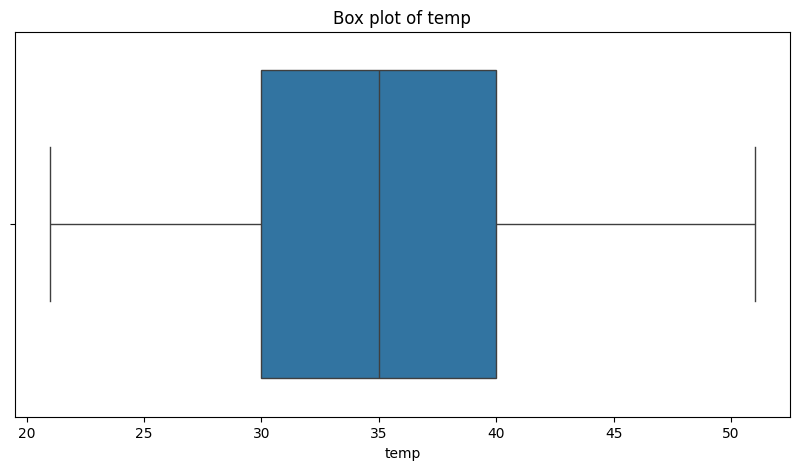

In [4]:

# Select numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot box plots for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()


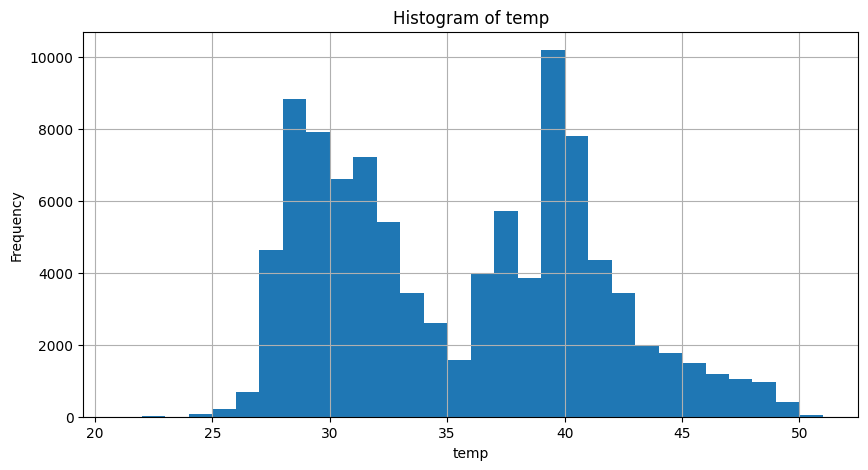

In [5]:
# Plot histograms for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [6]:
# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


In [7]:
# Split the dataset into Test and Train

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

Training set: (78084, 5)
Testing set: (19522, 5)


Model Selection and Training

Explore Nixtla's AutoML capabilities to select and train a forecasting model suitable for this dataset.
Document the model selection process and the reasoning behind the chosen model.

In [8]:
# Check if columns have already been renamed
if 'ds' in df.columns and 'y' in df.columns:
    print("Columns already renamed")
else:
    # Convert 'noted_date' to datetime format
    df['noted_date'] = pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M')

    # Rename columns to match the expected format for MLForecast
    df = df.rename(columns={'noted_date': 'ds', 'temp': 'y'})
    df['unique_id'] = 'temperature_series'  # Assuming a single time series



# Reorder columns to the expected order
df = df[['unique_id', 'ds', 'y']]

# Basic information and statistics
print(df.info())
print(df.describe())

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

models = {
    'RandomForrest': RandomForestRegressor(n_estimators=100),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100)
}

results = {}

for model_name, model in models.items():
    print(f"Fitting {model_name}...")
    forecaster = MLForecast(
        models=[
            (model)
        ],
        freq='D',  # Daily frequency
        lags=[1, 2, 3],  # Include lags 1, 2, and 3
        date_features=['year', 'month', 'day'],  # Include year, month, and day as date features
        num_threads= multiprocessing.cpu_count()  # Use cores from above for parallel processing
    )

    forecaster.fit(train)
    predictions = forecaster.predict(len(test))

    results[model_name] = predictions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  97606 non-null  object        
 1   ds         97606 non-null  datetime64[ns]
 2   y          97606 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ MB
None
                                  ds             y
count                          97606  97606.000000
mean   2018-10-07 05:10:38.821178880      0.468464
min              2018-07-28 07:06:00      0.000000
25%              2018-09-11 07:48:00      0.300000
50%              2018-10-17 05:10:00      0.466667
75%              2018-10-18 13:46:00      0.633333
max              2018-12-08 09:30:00      1.000000
std                              NaN      0.189994
Training set: (78084, 3)
Testing set: (19522, 3)
Fitting RandomForrest...
Fitting GradientBoosting...


Plotting the output comparing Test vs RandomForrestRegression and GradientBoostingRegression

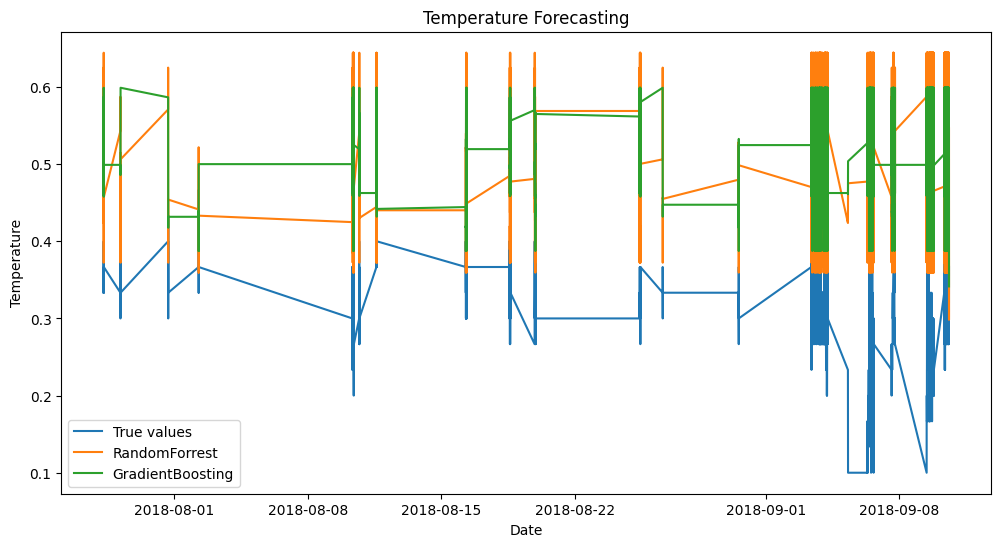

In [9]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='True values')

# Extract and plot predictions for each model
for model_name, predictions_df in results.items():
    # Extract the prediction column (third column in the DataFrame)
    predictions_series = predictions_df.iloc[:, 2]
    plt.plot(test['ds'], predictions_series, label=model_name)

plt.title('Temperature Forecasting')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Evaluation

Evaluate your model using appropriate time series metrics (e.g., MAE, MSE, MASE).
Perform rolling-origin cross-validation to ensure the model's robustness.
Summarize the evaluation results and discuss potential improvements.

In [10]:
# Evaluate the models

print("Model Evaluation:")
for model_name, predictions_df in results.items():
    predictions_series = predictions_df.iloc[:, 2]  # Extract the prediction column
    mae = mean_absolute_error(test['y'], predictions_series)
    mse = mean_squared_error(test['y'], predictions_series)
    print(f"{model_name}: MAE = {mae:.3f}, MSE = {mse:.3f}")
print("Closer to 0 is better")

Model Evaluation:
RandomForrest: MAE = 0.182, MSE = 0.039
GradientBoosting: MAE = 0.205, MSE = 0.047
Closer to 0 is better


Rolling-origin cross-validation to ensure the model's robustness.

In [11]:
# Function to perform rolling-origin cross-validation
def rolling_origin_cv(df, model, window_size, step_size):
    results = []
    n = len(df)
    
    for start in range(0, n - window_size, step_size):
        train = df.iloc[start:start + window_size]
        test = df.iloc[start + window_size:start + window_size + step_size]
        
        forecaster = MLForecast(
            models=[model],
            freq='D',
            lags=[1, 2, 3],
            date_features=['year', 'month', 'day'],
            num_threads=multiprocessing.cpu_count()  # Automatically use all available cores
        )
        
        forecaster.fit(train, id_col='unique_id', time_col='ds', target_col='y')
        
        predictions = forecaster.predict(len(test))

        # Ensure predictions are flattened if necessary
        if isinstance(predictions, pd.DataFrame):
            predictions = predictions.iloc[:, -1].values

        mae = mean_absolute_error(test['y'], predictions)
        mse = mean_squared_error(test['y'], predictions)
        
        results.append({'mae': mae, 'mse': mse})
    
    return pd.DataFrame(results)

# Use the correct subset of the dataframe
unique_df = df[['unique_id', 'ds', 'y']]

# Parameters for rolling-origin cross-validation
window_size = int(len(unique_df) * 0.6)  # Initial training window size (60% of data)
step_size = int(len(unique_df) * 0.2)    # Step size for moving window (20% of data)

# Define the model to evaluate
model = RandomForestRegressor(n_estimators=100)

# Perform rolling-origin cross-validation
cv_results = rolling_origin_cv(unique_df, model, window_size, step_size)

# Print results
print("Rolling-Origin Cross-Validation Results:")
print(cv_results)
print("\nAverage MAE:", cv_results['mae'].mean())
print("Average MSE:", cv_results['mse'].mean())


Rolling-Origin Cross-Validation Results:
        mae       mse
0  0.222615  0.058148
1  0.270492  0.079802
2  0.300333  0.090200

Average MAE: 0.2644797331929765
Average MSE: 0.07605005534035096


Summarize the evaluation results and discuss potential improvements.

# Generative Modeling

Apply a Variational Autoencoder (VAE) to generate synthetic time series data (as GANs can be computationally intensive).
Use the generated data to augment your training set.
Re-train your model with the augmented dataset and evaluate the performance improvements.

In [12]:
%pip install tensorflow pandas matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('IOT-temp.csv')

# Inspect for missing values and outliers, normalize if necessary
data = data.dropna()  # Simple handling of missing values

# Assuming 'value' is the column with the temperature data
values = data['temp'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
values_normalized = scaler.fit_transform(values)

# Split the data into training and testing sets
train_data, test_data = train_test_split(values_normalized, test_size=0.2, shuffle=False)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the encoder
latent_dim = 2

encoder_inputs = tf.keras.Input(shape=(1,))
x = layers.Dense(16, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Define the decoder
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation='relu')(decoder_inputs)
decoder_outputs = layers.Dense(1, activation='sigmoid')(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

# Define the VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, vae_outputs, name='vae')

# Define the VAE loss within the model's compile method
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))  # Mean Squared Error
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5
    return reconstruction_loss + kl_loss

# Custom training step
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss) * -0.5
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.summary()


2024-08-02 20:29:54.030662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 20:29:54.167852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 20:29:54.211261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 20:29:54.224207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 20:29:54.319829: I tensorflow/core/platform/cpu_feature_guar

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 2), (None, 2), │           100 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165 (660.00 B)

 Trainable params: 165 (660.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the VAE model
vae.fit(train_data, epochs=50, batch_size=32, validation_data=(test_data, None))


Epoch 1/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 3s 932us/step - loss: 0.0412 - val_loss: 0.0485
Epoch 2/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 863us/step - loss: 0.0352 - val_loss: 0.0507
Epoch 3/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - loss: 0.0354 - val_loss: 0.0494
Epoch 4/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step - loss: 0.0353 - val_loss: 0.0516
Epoch 5/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step - loss: 0.0353 - val_loss: 0.0488
Epoch 6/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - loss: 0.0355 - val_loss: 0.0477
Epoch 7/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - loss: 0.0351 - val_loss: 0.0475
Epoch 8/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - loss: 0.0353 - val_loss: 0.0496
Epoch 9/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 869us/step - loss: 0.0352 - val_loss: 0.0486
Epoch 10/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - loss: 0.0350 - val_loss: 0.0497
Epoch 11/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - loss: 0.0353 - val_loss: 0.0498
Epoch 12

In [16]:
# Generate synthetic data
n_samples = 1000  # Number of synthetic samples to generate
z_samples = np.random.normal(size=(n_samples, latent_dim))
generated_data = decoder.predict(z_samples)

# Inverse transform to get back to the original scale
generated_data = scaler.inverse_transform(generated_data)

# Convert to a DataFrame for further use
generated_df = pd.DataFrame(generated_data, columns=['value'])
generated_df.head()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,value
0,36.371155
1,36.371155
2,36.371155
3,36.371155
4,36.371155


In [17]:
# Augment the training set with the synthetic data
augmented_train_data = np.vstack([train_data, scaler.transform(generated_data)])

# Re-train your model with the augmented dataset
# Assuming you have a function `train_model` that trains your forecasting model
# train_model(augmented_train_data)

# Evaluate the performance improvements
# Assuming you have a function `evaluate_model` that evaluates your model
# evaluate_model()


In [18]:
# Define the model to evaluate
model = RandomForestRegressor(n_estimators=100)

forecaster = MLForecast(
    models=[
        (model)
    ],
    freq='D',  # Daily frequency
    lags=[1, 2, 3],  # Include lags 1, 2, and 3
    date_features=['year', 'month', 'day'],  # Include year, month, and day as date features
    num_threads= multiprocessing.cpu_count()  # Use cores from above for parallel processing
)


generated_train_size = int(len(generated_df) * 0.8)
generated_train, generated_test = df[:generated_train_size], df[generated_train_size:]

forecaster.fit(generated_train)
generated_prediction = forecaster.predict(len(generated_train))